In [1]:
from examples.seismic.source import RickerSource, TimeAxis
from examples.seismic import setup_geometry, PointSource, Receiver
from examples.seismic import SeismicModel
from examples.seismic.stiffness.model import ElasticModel
from examples.seismic.stiffness.utils import C_Matrix, D, S, vec
from devito import (Eq, Operator, VectorTimeFunction, TensorTimeFunction,
                    VectorFunction, solve)
from examples.seismic.stiffness import iso_elastic_setup
import numpy as np
import matplotlib.pyplot as plt
from devito import configuration, norm
configuration['log-level'] = 'WARNING'

mpi4py is not available. You must install it


In [2]:
nx=200
nz=200

shape = nx, nz
spacing = 10, 10
origin = 0., 0

nbl = 100
space_order=8

dtype=np.float32

vp = 3.5 * np.ones(shape, dtype=dtype)
rho = np.ones(shape, dtype=dtype)

vs = vp/2

# rho[:] = 0.31*(v[:]*1000.)**0.25
rho[:] = 1

In [3]:
model=ElasticModel(vp=vp, vs=vs, b=1/rho, origin=origin, space_order=space_order,
                     shape=shape, dtype=dtype, spacing=spacing, nbl=nbl)

In [4]:
# function to plot P wave velocity, S wave velocity and density models
def img_model(img1, img2, img3, model, title=""):

    plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0],
                         model.origin[0] + model.domain_size[0],
                         model.origin[1] + model.domain_size[1],
                         model.origin[1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

    scale1 = np.max(img1)
    scale2 = np.min(img1)

    imag1 = ax[0].imshow(np.transpose(img1), vmin=scale1, vmax=scale2,
                         **plt_options_model)
    fig.colorbar(imag1, ax=ax[0])
    ax[0].set_title("Vp (km/s)", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')

    scale3 = np.max(img2)
    scale4 = np.min(img2)

    imag2 = ax[1].imshow(np.transpose(img2), vmin=scale3, vmax=scale4,
                         **plt_options_model)
    fig.colorbar(imag2, ax=ax[1])
    ax[1].set_title("Vs (km/s)", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')

    scale5 = np.max(img3)
    scale6 = np.min(img3)

    imag3 = ax[2].imshow(np.transpose(img3), vmin=scale5, vmax=scale6,
                         **plt_options_model)
    fig.colorbar(imag3, ax=ax[2])
    ax[2].set_title(r"$\rho$ ($g/cm^3$)", fontsize=20)
    ax[2].set_xlabel('z (m)', fontsize=20)
    ax[2].set_ylabel('x (m)', fontsize=20)
    ax[2].set_aspect('auto')

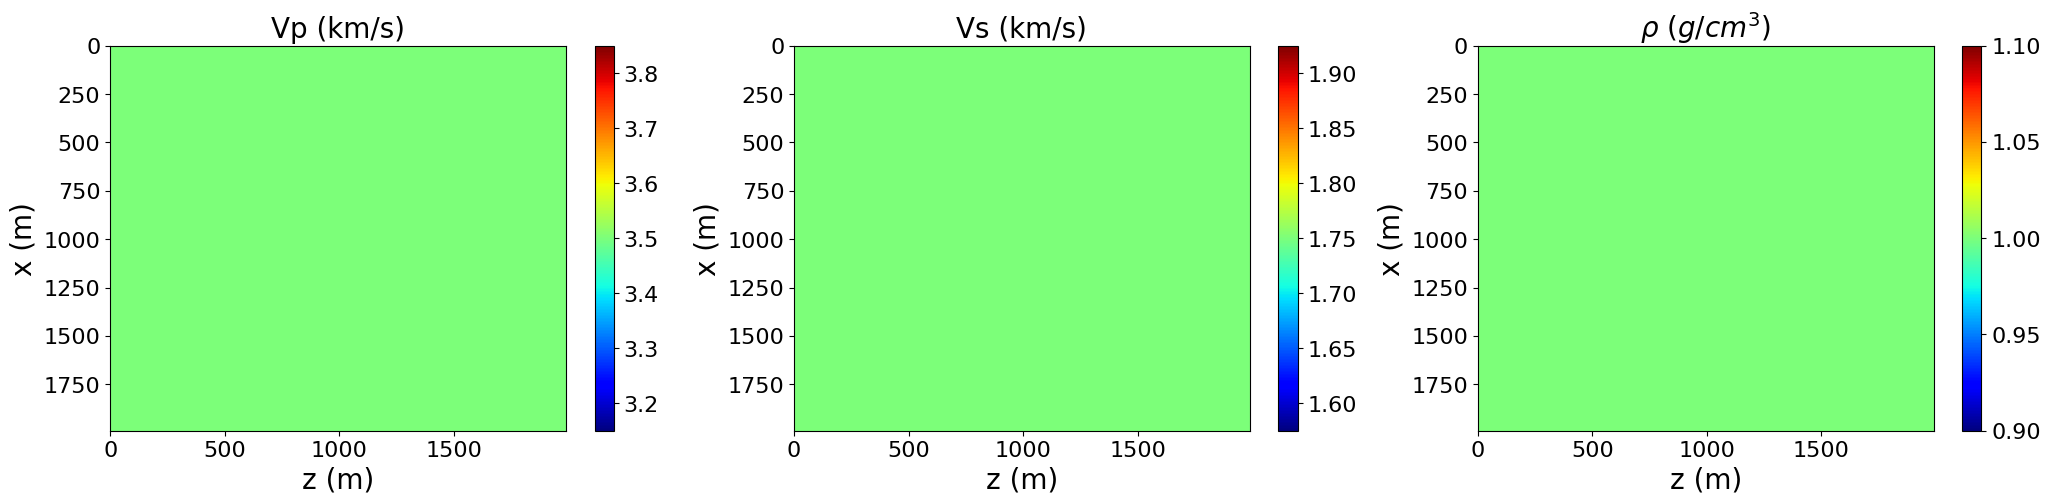

In [5]:
img_model(vp, vs, rho, model)

In [6]:
f0 = 0.020
t0, tn = 0, 1000
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)
s = model.grid.stepping_dim.spacing

In [7]:
geometry = setup_geometry(model, tn, f0=f0)

In [8]:
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0] = np.array(model.domain_size, dtype=dtype) * .5

In [9]:
C = C_Matrix(model,'vp-vs-rho')

In [10]:
sigma = vec(TensorTimeFunction(name='sigma', grid=model.grid, time_order=1, space_order=space_order, save=geometry.nt))
v0 = VectorTimeFunction(name='v0', grid=model.grid, time_order=1, space_order=space_order, save=geometry.nt)

In [11]:
PDE_sigma = sigma.dt - C * S(v0.forward)
PDE_v0 = 1/model.b * v0.dt - D(sigma)

stencil_sigma = Eq(sigma.forward, solve(PDE_sigma, sigma.forward))
stencil_v0 = Eq(v0.forward, solve(PDE_v0, v0.forward))

In [12]:
src_term_xx = src.inject(sigma[0].forward, expr = s * src)
src_term_zz = src.inject(sigma[1].forward, expr = s * src)
src_term = src_term_xx + src_term_zz

In [13]:
op = Operator([stencil_v0, stencil_sigma] + src_term, subs=model.spacing_map)

In [14]:
op(dt=dt)

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.24688700000000013, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=6.199999999999992e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

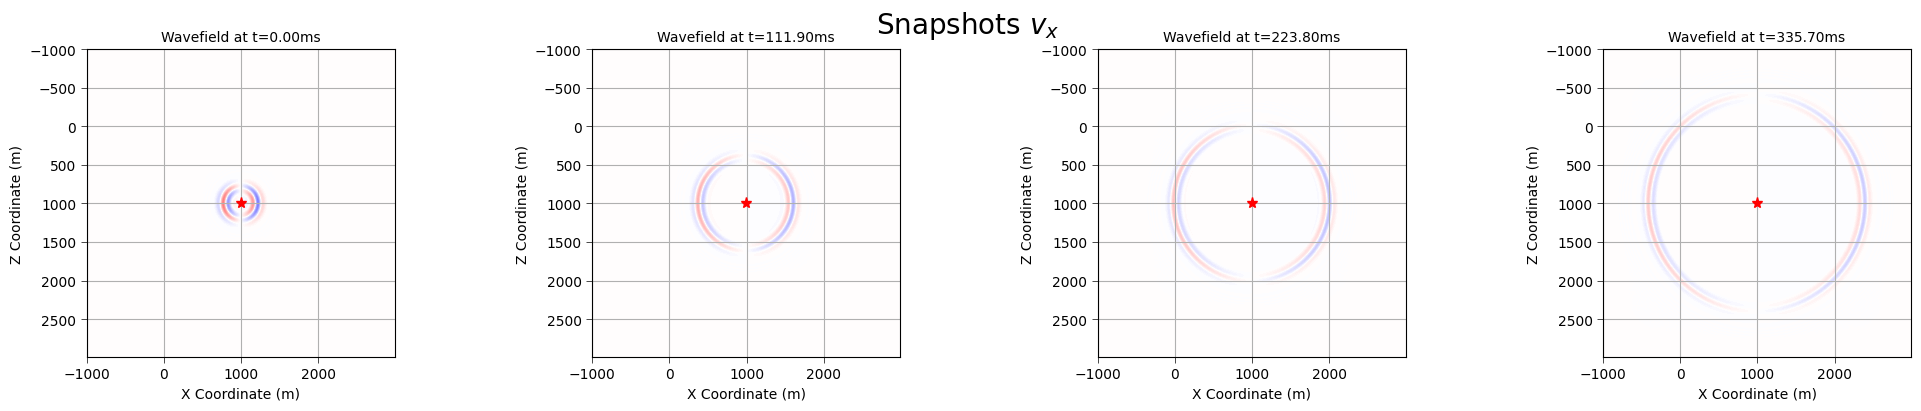

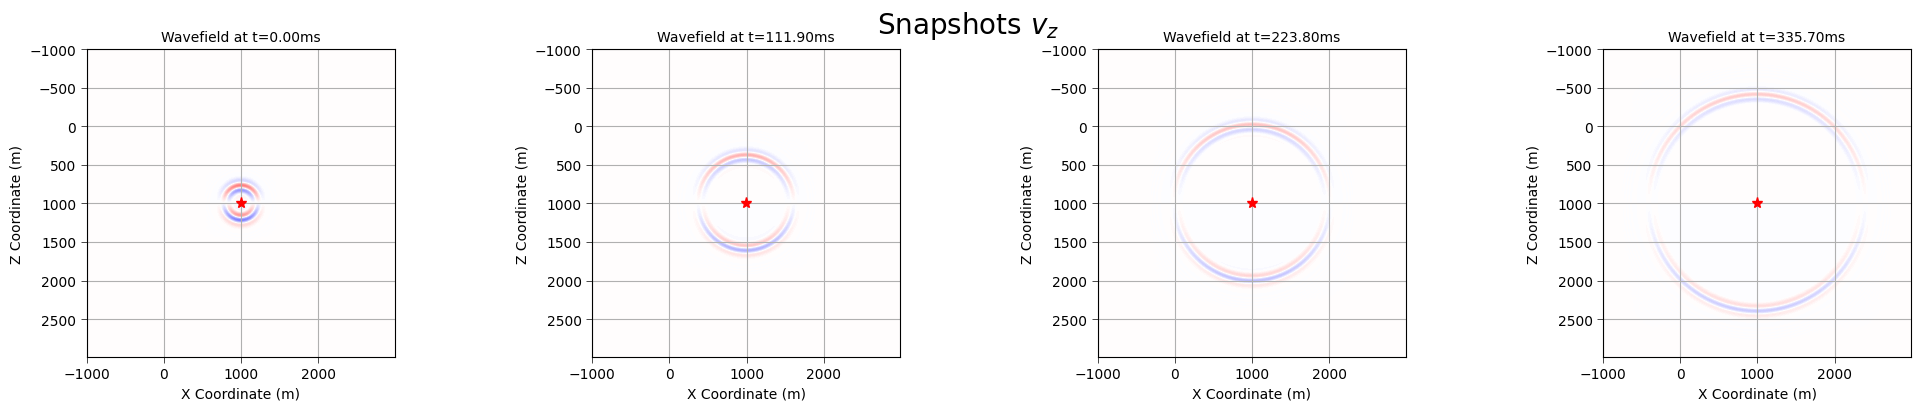

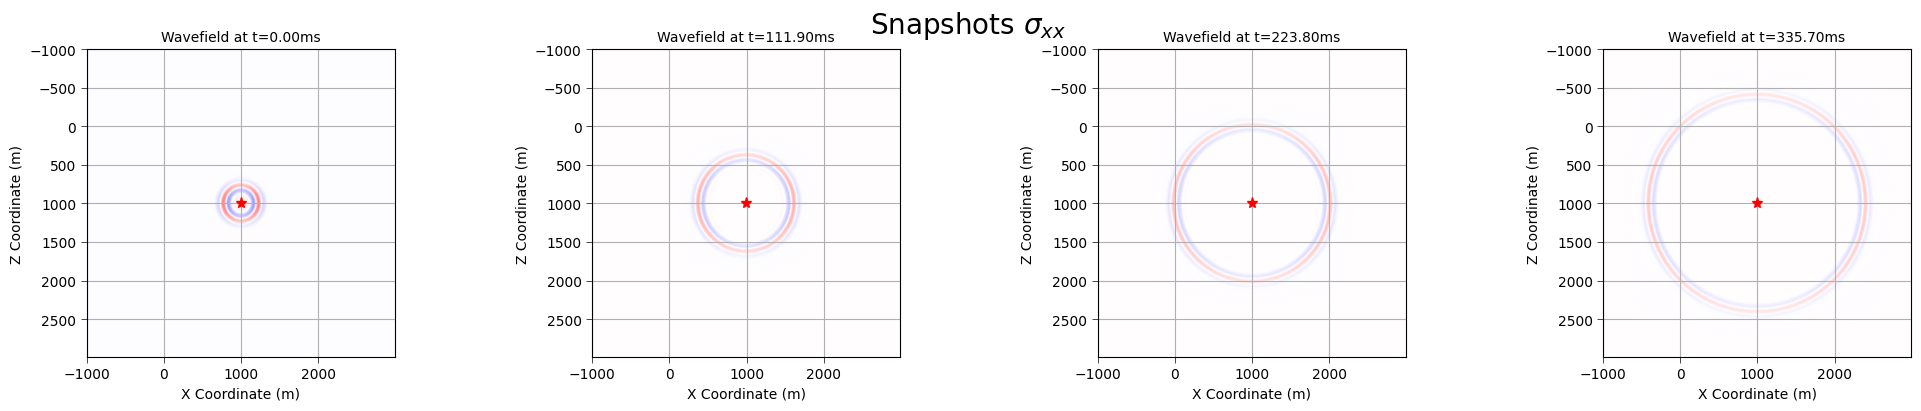

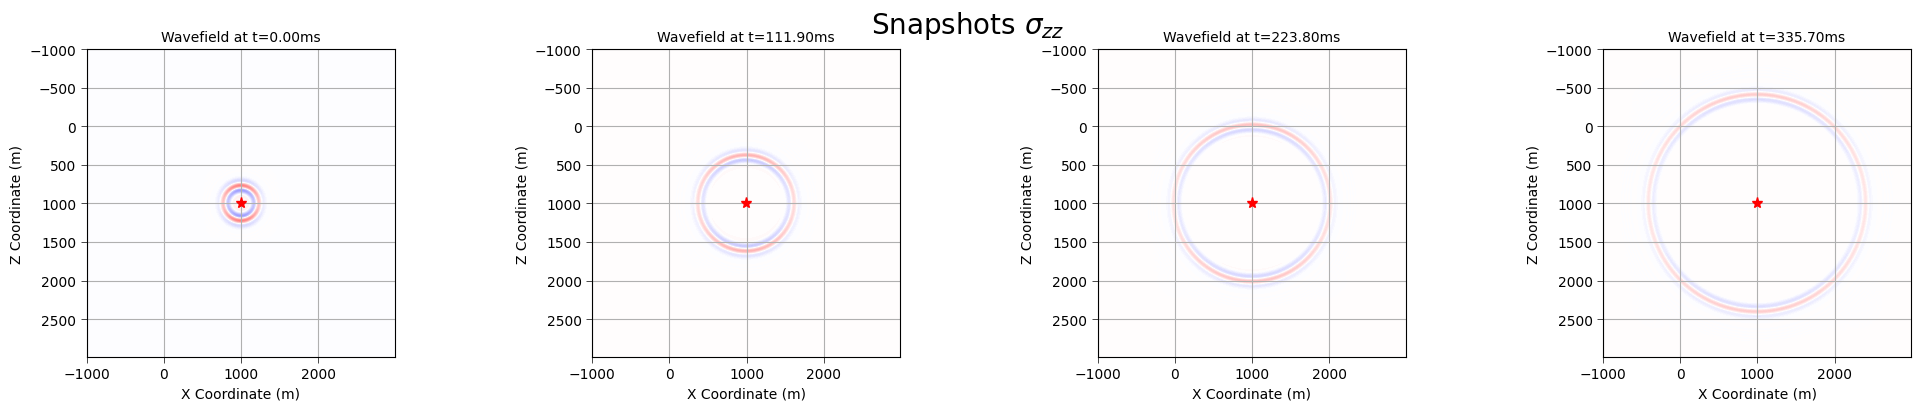

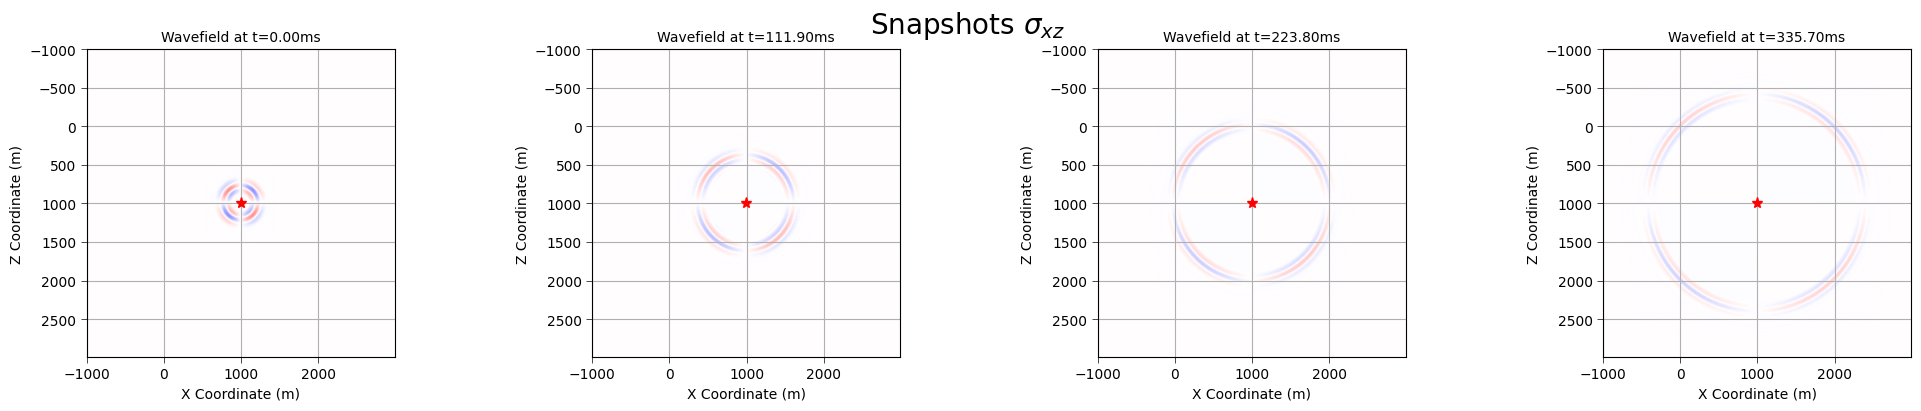

In [15]:
# NBVAL_IGNORE_OUTPUT
# Some useful definitions for plotting if nbl is set to any other value than zero
nxpad, nzpad = shape[0] + 2 * nbl, shape[1] + 2 * nbl
shape_pad = np.array(shape) + 2 * nbl
origin_pad = tuple([o - s*nbl for o, s in zip(origin, spacing)])
extent_pad = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])
# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]


def plot(a, title=None):
    # Plot the wavefields, each normalized to scaled maximum of last time step
    kt = (time_range.num - 2) - 1
    amax = 10 * np.max(np.abs(a.data[kt, :, :]))

    nsnaps = 9
    factor = round(time_range.num / nsnaps)

    fig, axes = plt.subplots(1, 4, figsize=(25, 4), sharex=True)
    fig.suptitle(title, size=20)
    for count, ax in enumerate(axes.ravel()):
        snapshot = factor * (count + 1)
        ax.imshow(np.transpose(a.data[snapshot, :, :]), cmap="seismic", vmin=-amax,
                  vmax=+amax, extent=plt_extent)
        ax.plot(model.domain_size[0] * .5, model.domain_size[1] * .5, 'red', linestyle='None', marker='*',
                markersize=8, label="Source")
        ax.grid()
        ax.tick_params('both', length=4, width=0.5, which='major', labelsize=10)
        ax.set_title("Wavefield at t=%.2fms" % (factor*count*dt), fontsize=10)
        ax.set_xlabel("X Coordinate (m)", fontsize=10)
        ax.set_ylabel("Z Coordinate (m)", fontsize=10)


plot(v0[0], title="Snapshots $v_x$")
plot(v0[1], title="Snapshots $v_z$")
plot(sigma[0], title="Snapshots $\sigma_{xx}$")
plot(sigma[1], title="Snapshots $\sigma_{zz}$")
plot(sigma[2], title="Snapshots $\sigma_{xz}$")